In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
%matplotlib inline

In [2]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        memory = self.encode(src, src_mask)
        return self.decode(tgt, memory, src_mask, tgt_mask)
    
    def encode(self, src, src_mask):
        _src = self.src_embed(src)
        return self.encoder(_src, src_mask)
    
    def decode(self, tgt, memory, src_mask, tgt_mask):
        _tgt = self.tgt_embed(tgt)
        return self.decoder(memory, _tgt, src_mask, tgt_mask)

In [3]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super().__init__()
        self.linear = nn.Linear(d_model, vocab)
        
    def forward(self, x):
        return F.log_softmax(self.linear(x), dim=-1)

In [4]:
from copy import deepcopy

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([deepcopy(module) for _ in range(N)])

class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, size, eps=1e-6):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(size))
        self.bias = nn.Parameter(torch.zeros(size))
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.scale * (x - mean) / (std + self.eps) + self.bias

In [5]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super().__init__()
        self.layers = clones(layer, N)
        size = layer.size
        self.norm = LayerNorm(size)
        
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [6]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, drop_prob):
        super().__init__()
        self.size = size
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(drop_prob)
        
    def forward(self, x, layer):
        next_x = layer(self.norm(x))
        return x + self.dropout(next_x)

In [7]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, drop_prob):
        super().__init__()
        self.size = size
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.norm = LayerNorm(size)
        self.sublayers = clones(SublayerConnection(size, drop_prob), 2)
        
    def forward(self, x, mask):
        x = self.sublayers[0](x, lambda x_: self.self_attn(x_, x_, x_, mask))
        x = self.sublayers[1](x, self.feed_forward)
        return self.norm(x)

In [8]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super().__init__()
        self.layers = clones(layer, N)
        size = layer.size
        self.norm = LayerNorm(size)
        
    def forward(self, memory, tgt, src_mask, tgt_mask):
        x = tgt
        for layer in self.layers:
            x = layer(memory, x, src_mask, tgt_mask)
        return self.norm(x)

In [9]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, drop_prob):
        super().__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn  = src_attn
        self.feed_forward = feed_forward
        self.sublayers = clones(SublayerConnection(size, drop_prob), 3)
    
    def forward(self, memory, tgt, src_mask, tgt_mask):
        m = memory
        x = tgt
        x = self.sublayers[0](x, lambda x_: self.self_attn(x_, x_, x_, tgt_mask))
        x = self.sublayers[1](x, lambda x_: self.src_attn(x_, m, m, src_mask))
        x = self.sublayers[2](x, self.feed_forward)
        return x

In [10]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask)

In [11]:
plt.figure(figsize=(5, 5))
mask = subsequent_mask(5)
mask[0]

tensor([[ 0,  1,  1,  1,  1],
        [ 0,  0,  1,  1,  1],
        [ 0,  0,  0,  1,  1],
        [ 0,  0,  0,  0,  1],
        [ 0,  0,  0,  0,  0]], dtype=torch.uint8)

In [12]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    # qurey.size == (n_batch, input_length, n_head, key_dim)
    # key.size == (n_batch, memory_length, n_head, key_dim)
    # value.size == (n_batch, memory_length, n_head, value_dim)
    q_k = torch.matmul(query, key.transpose(-1, -2))
    key_dim = query.size()[-1]
    scores = q_k / np.sqrt(key_dim)
    if mask is not None:
        scores = scores.masked_fill(mask, -1e9)
    # attention.size == (n_batch, input_length, memory_length)
    attention = F.softmax(scores)
    if dropout is not None:
        attention = dropout(attention)
    # output.size == (n_batch, input_length, value_dim)
    output = torch.matmul(attention, value)
    return output, attention

In [13]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, drop_prob=0.1):
        super().__init__()
        self.h = h
        self.d_model = d_model
        self.h_dim = d_model // h
        self.linears = clones(nn.Linear(d_model, d_model), 3)
        self.o_linear = nn.Linear(h * self.h_dim, d_model)
        self.dropout = nn.Dropout(drop_prob)
        
    def forward(self, query, key, value, mask):
        outputs = list()
        inputs = (query, key, value)
        projs = list()
        for x, lin in zip(inputs, self.linears):
            x = lin(x)
            # Split for multi head
            x = torch.cat(torch.chunk(x, self.h, dim=-1), dim=0)
            projs.append(x)
        proj_q, proj_k, proj_v = projs
        mask = torch.cat([deepcopy(mask)] * 8, dim=0)
        output, self.attn = attention(proj_q, proj_k, proj_v,
                                      mask=mask, dropout=self.dropout)
        self.attn = torch.cat(torch.chunk(self.attn, self.h, dim=0), dim=-1)
        output = torch.cat(torch.chunk(output, self.h, dim=0), dim=-1)
        return self.o_linear(output)

In [14]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, drop_prob=0.1):
        super().__init__()
        self.lin1 = nn.Linear(d_model, d_ff)
        self.lin2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(drop_prob)
        
    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = self.dropout(x)
        return self.lin2(x)

In [15]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super().__init__()
        self.embeds = nn.Embedding(vocab, d_model)
        self.d_model = d_model
        
    def forward(self, x):
        return self.embeds(x) * np.sqrt(self.d_model)

In [16]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, drop_prob, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(drop_prob)
        # Positional Encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        const = 1e4
        div_term = torch.exp(torch.arange(0, d_model, 2) *\
                             -(np.log(const) / d_model))
        div_term = div_term.unsqueeze(0)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, x.size(1)],
                         requires_grad=False)
        return self.dropout(x)

In [17]:
def make_model(src_vocab, tgt_vocab, N=6,
               d_model=512, d_ff=2048, h=8, drop_prob=0.1):
    attn = MultiHeadedAttention(h, d_model, drop_prob)
    ff = PositionwiseFeedForward(d_model, d_ff, drop_prob)
    pe = PositionalEncoding(d_model, drop_prob)
    c = deepcopy
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), drop_prob), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), drop_prob), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(pe)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(pe)),
        Generator(d_model, tgt_vocab))
    
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [18]:
tmp_model = make_model(10, 10, 2)

In [19]:
class Batch:
    def __init__(self, src, tgt=None, pad=0):
        # src.size == (n_batch, length)
        self.src = src
        # src_mask has 1 when src is 0
        # Shape has to be (n_batch, tgt_length, memory_length)
        self.src_mask = (src == pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = \
                self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y == pad).data.sum()
            
    @staticmethod
    def make_std_mask(tgt, pad):
        length = tgt.size(-1)
        tgt_mask = (tgt == pad).unsqueeze(-1)
        seq_mask = Variable(subsequent_mask(length).type_as(tgt_mask.data))
        tgt_mask = tgt_mask | seq_mask
        return tgt_mask

In [20]:
import time


def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.tgt, 
                            batch.src_mask, batch.tgt_mask)
        loss = loss_compute(out, batch.tgt_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            # print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
            print(i, loss, tokens / elapsed)
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [21]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch, len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch, len(new.tgt) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, max_tgt_in_batch)

In [22]:
class NoamOpt:
    def __init__(self,  model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p["lr"] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step=None):
        if step is None:
            step  = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
                   torch.optim.Adam(model.paramters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [23]:
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx, smoothing=0.0):
        super().__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, tgt):
        # x.size == (n_batch * length, vocab)
        # tgt.size == (n_batch * length)
        assert x.size(-1) == self.size
        true_dist = x.clone()
        # Subtract 2 because of padding index and eos index
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, tgt.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(tgt == self.padding_idx)
        if mask.dim() > 0 and len(mask) > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

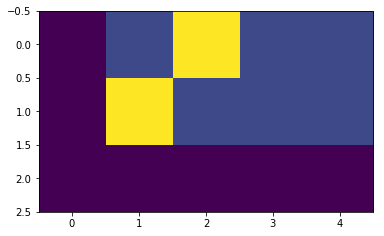

In [24]:
# Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

In [25]:
def data_gen(V, batch, nbatches):
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

In [ ]:
class SimpleLossCompute:
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        norm = float(norm)
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm

In [ ]:
V = 11
criterion = LabelSmoothing(size=V,  padding_idx=0,  smoothing=0.1)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, 
                    SimpleLossCompute(model.generator, criterion, None)))

/home/tomoaki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


In [ ]:
opt = torch.optim.Adam(tmp_model.parameters())

In [ ]:
opt.

In [ ]:
x.unsqueeze(0)

In [ ]:
help(x.scatter_)